# Imports and setup

In [48]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import re
import pgeocode

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, TargetEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.metrics.pairwise import haversine_distances
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import LeaveOneOut
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from scipy.sparse import hstack
from scipy.stats.mstats import hmean

from lightgbm import LGBMRegressor

pd.set_option('display.max_columns', None)

In [49]:
TODAY = pd.to_datetime('2024-01-01')

In [50]:
## Read in and preview data
df = pd.read_csv('../data/train.csv')
df = df.drop(columns=['Id'])
df['host_id'] = df['host_id'].astype(str)
df.head()

,price,name,neighborhood_overview,host_id,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
0,143.0,Guesthouse in Oakland · ★4.93 · 1 bedroom · 1 ...,You will be in the Crocker Highlands neighborh...,4211733,2012-11-21,"Oakland, CA",NaN,within a few hours,100%,89%,f,1.0,"['email', 'phone']",t,t,Lakeshore,37.815091,-122.237531,Entire guesthouse,Entire home/apt,4,1 bath,NaN,1.0,[],3,365,3,3,365,365,3.0,365.0,t,16,41,71,346,14,14,2,2023-04-28,2023-11-26,4.93,5.00,4.86,4.86,5.00,4.93,4.86,f
1,103.0,Rental unit in San Francisco · 1 bedroom · 1 b...,NaN,1257432,2011-10-06,"San Francisco, CA","Our Company is San Francisco Life Real Estate,...",within an hour,98%,81%,t,32.0,"['email', 'phone', 'work_email']",t,t,Western Addition,37.770767,-122.427483,Entire rental unit,Entire home/apt,2,1 bath,NaN,1.0,"[""Hair dryer"", ""TV"", ""Dishwasher"", ""Elevator"",...",30,365,30,30,365,365,30.0,365.0,t,17,40,43,317,2,2,0,2023-09-05,2023-10-31,5.00,4.50,4.50,5.00,5.00,5.00,4.50,f
2,55.0,Home in San Francisco · ★5.0 · 1 bedroom · 1 b...,NaN,9219277,2013-10-04,"San Francisco, CA",Hi there! My name's Henry and my wife and I ha...,within an hour,100%,85%,t,10.0,"['email', 'phone']",t,t,Outer Sunset,37.759270,-122.482580,Private room in home,Private room,2,1.5 shared baths,NaN,1.0,"[""Dining table"", ""Hot water kettle"", ""Paid was...",30,92,30,30,92,92,30.0,92.0,t,5,35,65,154,4,0,0,2021-12-17,2022-11-10,5.00,4.75,4.75,5.00,5.00,5.00,3.75,f
3,80.0,Home in Palo Alto · ★5.0 · 1 bedroom · 1 bed ·...,This is a very safe neighborhood with low crim...,13149124,2014-03-15,"Palo Alto, CA",Hi! I work in tech but enjoy running Airbnb on...,within a day,90%,56%,t,3.0,"['email', 'phone']",t,t,Palo Alto,37.410960,-122.121440,Private room in home,Private room,1,1.5 shared baths,NaN,1.0,[],1,1125,1,1,1125,1125,1.0,1125.0,t,1,1,1,114,7,1,0,2021-08-28,2023-05-27,5.00,5.00,5.00,5.00,5.00,4.86,5.00,f
4,259.0,Hotel in Sunnyvale · ★4.75 · 1 bedroom · 2 bed...,De Anza College – 4.3 miles; <br />Computer Hi...,501999278,2023-02-20,NaN,NaN,within an hour,100%,88%,f,1781.0,"['email', 'phone']",t,t,Sunnyvale,37.370190,-122.043740,Room in hotel,Private room,4,1 bath,NaN,2.0,[],1,1125,1,1,1,1125,1.0,516.3,t,26,36,36,196,8,8,1,2023-06-11,2023-11-26,4.75,4.88,4.75,5.00,4.88,4.88,4.88,t


TODO: should this be applied to entire df or only X?

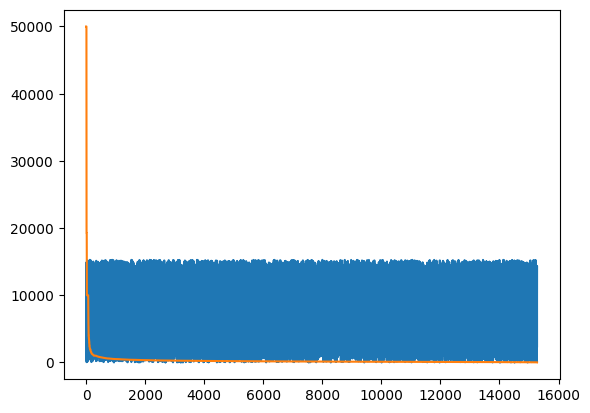

In [51]:
plt.plot(df.price.sort_values(ascending=False).reset_index())

In [52]:
## Drop all instances with prices > 3000 to avoid using poor quality data
df = df[df.price <= 3000]

In [53]:
# df.loc[df.price > 5000, 'price'] = df.loc[df.price > 5000, 'price'] / 4

In [54]:
# import seaborn as sns

# ## Create histogram of price
# sns.histplot(df['price'], bins=50, kde=True)
# ## Change x axis limit to zoom in on the majority of the data
# #plt.xlim(0, 5000)


In [55]:
## Split data into features and target
X_orig = df.drop('price', axis=1)
y_orig = df['price']

## Drop columns right away
DROP_COLS = ['name', 'neighborhood_overview', 'host_location', 'host_about', 'host_has_profile_pic']

X_orig = X_orig.drop(DROP_COLS, axis=1)

# Pre-Split Feature engineering

#### Simple transformations

Fix dtypes, normalize, etc.

In [56]:
def pre_split_engineering(X):
    ## Fix boolean columns
    X['host_is_superhost'] = X['host_is_superhost'].map({'t': 1, 'f': 0})
    X['host_identity_verified'] = X['host_identity_verified'].map({'t': 1, 'f': 0})
    X['instant_bookable'] = X['instant_bookable'].map({'t': 1, 'f': 0})
    X['has_availability'] = X['has_availability'].map({'t': 1, 'f': 0})

    ## Fix percentage columns
    X['host_response_rate'] = X['host_response_rate'].str.replace('%', '').astype(float) / 100
    X['host_acceptance_rate'] = X['host_acceptance_rate'].str.replace('%', '').astype(float) / 100

    ## Convert dates to durations
    X['host_lifetime'] = (TODAY - pd.to_datetime(X['host_since'])).dt.days # December 2023 
    X = X.drop('host_since', axis=1)

    X['days_since_first_review'] = (TODAY - pd.to_datetime(X['first_review'])).dt.days # December 2023
    X = X.drop('first_review', axis=1)

    X['days_since_last_review'] = (TODAY - pd.to_datetime(X['last_review'])).dt.days # December 2023
    X = X.drop('last_review', axis=1)

    ## Calculate availability percentage
    X['avg_availability'] = X['availability_365'] / 365
    #X = X.drop(columns=['has_availability','availability_30','availability_60','availability_90','availability_365'])

    ## Add hours to host_response_time
    X['host_response_time'] = X['host_response_time'].map({
        'within an hour': 1,
        'within a few hours': 6,
        'within a day': 24,
        'a few days or more': 48,
    })

    ### ENGINEER LOCATION ###

    ## Extract number from bathrooms_text column
    X['n_bathrooms'] = X['bathrooms_text'].str.extract('(\d+)').astype(float)
    X = X.drop('bathrooms_text', axis=1)

    # ## Engineer latitude and longitude
    X['latitude_rad'] = np.radians(X['latitude'])
    X['longitude_rad'] = np.radians(X['longitude'])

    X['coord_x'] = np.cos(X['latitude']) * np.cos(X['longitude'])
    X['coord_y'] = np.cos(X['latitude']) * np.sin(X['longitude'])
    # X['coord_interaction'] = X['coord_x'] * X['coord_y']

    # # ## Calculate haversine distance between each listing and bay center (prox for proximity to water)
    TARGET_LAT = 37.4277# 37.695484
    TARGET_LON = -122.1701 #-122.304152
    TARGET_RAD = np.radians([TARGET_LAT, TARGET_LON])
    X['dist_to_water'] = haversine_distances(np.array([X['latitude_rad'],X['longitude_rad']]).T, TARGET_RAD.reshape(1, -1))

    X = X.drop(columns=['latitude', 'longitude'])

    ### TEXT TRANSFORMATIONS ###

    ## Convert stringified lists to comma separated text for CountVectorizer
    X['amenities'] = X['amenities'].fillna('None')
    X['host_verifications'] = X['host_verifications'].fillna('None')

    X['amenities'] = X['amenities'].apply(lambda x: x.strip('][').replace("'",'').replace('"',''))
    X['host_verifications'] = X['host_verifications'].apply(lambda x: x.strip('][').replace("'",'').replace('"',''))

    ## To convert to list: #.apply(lambda x: x.strip('][').replace("'",'').split(', '))

    X['n_amenities'] = X['amenities'].apply(lambda x: len(x.split(',')))
    X = X.drop('amenities', axis=1)

    return X

In [57]:
# print(X_orig.room_type.value_counts())
# df.groupby('room_type').price.mean()

In [58]:
def pre_split_drop(X):
    PRE_SPLIT_DROP = [
        'has_availability', # drop
        'host_lifetime', 
        'days_since_first_review', 
        'days_since_last_review',
        'host_response_time', # drop
        #####'latitude_rad', # TODO: keep? ITER 1
        #'longitude_rad' 
        'coord_x',
        'coord_y',
        'dist_to_water',
        'host_listings_count', 
        'n_amenities',
        'host_verifications', # TODO: encode?
        'bedrooms', 
        #####'beds',  
        'minimum_nights',
        'maximum_nights', 
        'minimum_minimum_nights', 
        'maximum_minimum_nights',
        'minimum_maximum_nights', 
        'maximum_maximum_nights',
        'minimum_nights_avg_ntm',
        'maximum_nights_avg_ntm', 
        #####'host_id', ITER 1
        #####'review_scores_rating', 
        'review_scores_accuracy',
        'review_scores_cleanliness', 
        'review_scores_checkin',
        'review_scores_communication',
        'review_scores_location',
        'review_scores_value',
        'availability_30', 
        'availability_60', 
        'number_of_reviews', 
        'number_of_reviews_ltm',
        'number_of_reviews_l30d',

        'neighbourhood_cleansed', ## TODO: encoding these doesn't help.... ????
        'property_type', ## TODO: encoding these doesn't help.... ????
        #####'room_type' ## TODO: encoding these doesn't help.... ????
    ]

    X = X.drop(PRE_SPLIT_DROP, axis=1)

    return X

In [59]:
X_engineered = pre_split_engineering(X_orig)
X_cleaned = pre_split_drop(X_engineered)

In [60]:
X_cleaned

,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,room_type,accommodates,beds,availability_90,availability_365,review_scores_rating,instant_bookable,avg_availability,n_bathrooms,latitude_rad,longitude_rad
0,4211733,1.00,0.89,0.0,1.0,Entire home/apt,4,1.0,71,346,4.93,0,0.947945,1.0,0.659998,-2.133447
1,1257432,0.98,0.81,1.0,1.0,Entire home/apt,2,1.0,43,317,5.00,0,0.868493,1.0,0.659224,-2.136763
2,9219277,1.00,0.85,1.0,1.0,Private room,2,1.0,65,154,5.00,0,0.421918,1.0,0.659024,-2.137724
3,13149124,0.90,0.56,1.0,1.0,Private room,1,1.0,1,114,5.00,0,0.312329,1.0,0.652944,-2.131421
4,501999278,1.00,0.88,0.0,1.0,Private room,4,2.0,36,196,4.75,1,0.536986,1.0,0.652233,-2.130065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15269,24910,1.00,1.00,1.0,1.0,Entire home/apt,6,3.0,1,149,4.89,0,0.408219,1.0,0.658984,-2.136590
15270,378727622,1.00,1.00,0.0,1.0,Entire home/apt,4,2.0,73,73,4.73,1,0.200000,1.0,0.657823,-2.137345
15271,471777228,0.90,1.00,1.0,0.0,Entire home/apt,16,13.0,80,351,4.96,1,0.961644,5.0,0.650198,-2.130514
15272,84170936,1.00,1.00,1.0,1.0,Entire home/apt,5,2.0,79,332,4.99,0,0.909589,1.0,0.645170,-2.128636


# Post-split feature engineering

In [36]:
def post_split_engineering(X_train, X_test, y_train):
    TARGET_ENCODE_COLS = ['host_id']#,'property_type','room_type']
    
    for col in TARGET_ENCODE_COLS:
        enc = TargetEncoder()
        X_train[col] = enc.fit_transform(np.array(X_train[col]).reshape(-1,1), y_train)
        X_test[col] = enc.transform(np.array(X_test[col]).reshape(-1,1))

    X_train = X_train.drop(columns=['host_id'])
    X_test = X_test.drop(columns=['host_id'])

    ## Define pipeline for numeric features
    numeric_pipe = Pipeline([ # NOTE: assumes preprocessor has already been run
        ('impute', IterativeImputer()),
        ('poly',PolynomialFeatures(interaction_only=True, include_bias=False)),#degree=2, include_bias=False)),
        #('standardize',StandardScaler(with_mean=True, with_std=True))
    ])

    ## Create col transformer for numeric features
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    numeric_transformer = ColumnTransformer([
        ('num', numeric_pipe, numeric_features)
    ])

    cols = X_train.columns
    X_train = numeric_transformer.fit_transform(X_train, y_train) #numeric_pipe.fit_transform(X_train, y_train)
    X_test = numeric_transformer.transform(X_test) #numeric_pipe.transform(X_test)

    clustering = KMeans(n_clusters=2)
    train_cluster_labels = clustering.fit_predict(X_train)
    test_cluster_labels = clustering.fit_predict(X_test)

    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)

    # ## Add column to X_train and X_test
    # X_train[:, -1] = train_cluster_labels
    # X_test[:, -1] = test_cluster_labels

    ## Add column to X_train and X_test
    X_train['cluster'] = train_cluster_labels
    X_test['cluster'] = test_cluster_labels

    # Add average y by cluster

    # enc_2 = TargetEncoder()
    # train_encoding = pd.Series(enc_2.fit_transform(np.array(X_train['cluster']).reshape(-1,1), y_train))
    # test_encoding = pd.Series(enc_2.transform(np.array(X_test['cluster']).reshape(-1,1)))
    # X_train = pd.concat([X_train, train_encoding], axis=1)
    # X_test = pd.concat([X_test, test_encoding],axis=1)

    return X_train, X_test, y_train

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_orig, test_size=0.2, random_state=9) # Joe Burrow

In [38]:
X_train, X_test, y_train = post_split_engineering(X_train, X_test, y_train)

/home/scottbrown/byu/stat486/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [39]:
# # Normalize 5-star reviews to percentage using min-max scaling with 1 as min and 5 as max
# RATING_COLS = [col for col in X_train.columns if 'review_scores' in col]

# for col in RATING_COLS:
#     X_train[col] = (X_train[col] - 1) / (5 - 1)
#     X_test[col] = (X_test[col] - 1) / (5 - 1)

# # Combine and normalize review scores
# # X_train['review_scores'] = X_train[RATING_COLS].mean(axis=1)
# # X_test['review_scores'] = X_test[RATING_COLS].mean(axis=1)
# # X_train['review_scores'] = (X_train['review_scores'] - 1) / (5 - 1)
# # X_test['review_scores'] = (X_test['review_scores'] - 1) / (5 - 1)
# # X_train['review_scores_rank'] = X_train['review_scores'].rank(pct=True)
# # X_test['review_scores_rank'] = X_test['review_scores'].rank(pct=True)

# # Drop original review score columns
# # X_train = X_train.drop(RATING_COLS, axis=1)
# # X_test = X_test.drop(RATING_COLS, axis=1)

In [40]:
# ## Manually target encode using formula encoding = weight * in_category + (1 - weight) * overall
# TARGET_ENCODE_COLS = ['property_type']
# CATEGORY_WEIGHT = 0.5
# OTHER_THRESHOLD = 10
# overall_mean = y_train.mean()

# ## Combine low-frequency host_ids into 'other' 
# for col in TARGET_ENCODE_COLS:
#     X_train.loc[X_train[col].map(X_train[col].value_counts() < OTHER_THRESHOLD), col] = 'other'
#     in_category_mean = y_train.groupby(X_train[col]).mean()

#     ## Create mapping
#     map = CATEGORY_WEIGHT * in_category_mean + (1 - CATEGORY_WEIGHT) * overall_mean

#     # Apply mapping
#     X_train[f'{col}_enc'] = X_train[col].map(map).fillna(overall_mean)
#     X_test[f'{col}_enc'] = X_test[col].map(map).fillna(overall_mean)

#     X_train = X_train.drop(col, axis=1)
#     X_test = X_test.drop(col, axis=1)

In [41]:
# ## Target encode neighbourhood_cleansed

# OTHER_THRESHOLD = 20

# ## Combine low-frequency neighbourhood_cleansed into 'other'
# X_train.loc[X_train['neighbourhood_cleansed'].map(X_train['neighbourhood_cleansed'].value_counts() < OTHER_THRESHOLD), 'neighbourhood_cleansed'] = 'other'
# X_test.loc[X_test['neighbourhood_cleansed'].map(X_test['neighbourhood_cleansed'].value_counts() < OTHER_THRESHOLD), 'neighbourhood_cleansed'] = 'other'

# # enc = TargetEncoder()
# X_train['neighbourhood_cleansed'] = enc.fit_transform(np.array(X_train['neighbourhood_cleansed']).reshape(-1,1), y_train)
# X_test['neighbourhood_cleansed'] = enc.transform(np.array(X_test['neighbourhood_cleansed']).reshape(-1,1))

In [42]:
# # X_train = X_train.drop(columns=['neighbourhood_cleansed','property_type','room_type'], axis=1)
# # X_test = X_test.drop(columns=['neighbourhood_cleansed','property_type','room_type'], axis=1)

# ## Define pipeline for numeric features
# numeric_pipe = Pipeline([
#   ('impute', IterativeImputer()),
#   #('poly',PolynomialFeatures(interaction_only=False, include_bias=False)),#degree=2, include_bias=False)),
#   #('standardize',StandardScaler(with_mean=True, with_std=True))
# ])

# cols = X_train.columns
# X_train = numeric_pipe.fit_transform(X_train, y_train)
# X_test = numeric_pipe.transform(X_test)

In [43]:
# ## Standardize only certain columns
# standardize_cols = ['accommodates','availability_365']
# std_indices  = [np.where(cols == col)[0][0] for col in standardize_cols]

# standardizer = StandardScaler(with_std)
# X_train[:,std_indices] = standardizer.fit_transform(X_train[:,std_indices])
# X_test[:,std_indices] = standardizer.transform(X_test[:,std_indices])

# Perform Clustering

In [44]:
# ## Perform clustering on training data
# from sklearn.cluster import KMeans, DBSCAN

# clustering = KMeans(n_clusters=3, n_init='auto') # Joe Burrow
# #clustering = KMeans(n_clusters=3, n_init='auto')
# clustering.fit(np.concatenate([X_train, X_test], axis=0))

# cluster_labels = clustering.predict(np.concatenate([X_train, X_test]))
# X_train[:,:-1] = cluster_labels[:X_train.shape[0]].reshape(-1,1)
# X_test[:,:-1] = cluster_labels[X_train.shape[0]:].reshape(-1,1)

# # X_train['cluster'] = cluster_labels[:X_train.shape[0]]
# # X_test['cluster'] = cluster_labels[X_train.shape[0]:]

# Predict new values

In [45]:
testing_model = LGBMRegressor(num_iterations=500, learning_rate=0.1, random_state=9) # Joe Burrow objective='huber'
testing_model.fit(X_train, np.log(y_train))

/home/scottbrown/byu/stat486/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20800
[LightGBM] [Info] Number of data points in the train set: 12137, number of used features: 106
[LightGBM] [Info] Start training from score 4.986495


LGBMRegressor(num_iterations=500, random_state=9)

In [47]:
y_pred_testing = np.exp(testing_model.predict(X_test))
mean_absolute_error(y_test, y_pred_testing)

63.45974705527395

In [23]:
# final_model = KNeighborsRegressor(n_neighbors=9, weights='distance')
# #final_model = DecisionTreeRegressor(min_samples_split=24, min_samples_leaf=6, max_features=26, max_depth=7)

# final_model.fit(X_train, np.log(y_train)) #np.log(y_train))
# y_pred = np.exp(final_model.predict(X_test)) #np.exp(final_model.predict(X_test))
# mean_absolute_error(y_test, y_pred)

In [24]:
# tuned_model = DecisionTreeRegressor()

# ## Tune hyperparameters with random search
# param_distributions = {
#     'max_depth': range(1,101),
#     'max_features': range(1, X_train.shape[1] + 1),
#     'min_samples_split': range(2,25),
#     'min_samples_leaf': range(1,25),
# }

# search = RandomizedSearchCV(tuned_model, param_distributions, n_iter=100, cv=5, scoring='neg_mean_absolute_error', random_state=9)

# search.fit(X_train, np.log(y_train))
# print(search.best_params_)

# y_pred = np.exp(search.predict(X_test))
# mean_absolute_error(y_test, y_pred)

# PREDICT FOR KAGGLE

In [25]:
## Read in and preview data
data = pd.read_csv('../data/train.csv')
newdata = pd.read_csv('../data/test.csv')

data = data.drop(columns=['Id'])
new_data_id = newdata['Id']
newdata = newdata.drop(columns=['Id'])

data['host_id'] = data['host_id'].astype(str)
newdata['host_id'] = newdata['host_id'].astype(str)

## Drop columns right away
DROP_COLS = ['name', 'neighborhood_overview', 'host_location', 'host_about', 'host_has_profile_pic']

data = data.drop(DROP_COLS, axis=1)
newdata = newdata.drop(DROP_COLS, axis=1)

## Split data into features and target
X = data.drop('price', axis=1)
y = data['price']

In [26]:
X_1 = pre_split_engineering(X)
newdata_1 = pre_split_engineering(newdata)

In [27]:
X_2  = pre_split_drop(X_1)
newdata_2 = pre_split_drop(newdata_1)

In [28]:
X, newdata_final, y = post_split_engineering(X_train=X_2, X_test=newdata_2, y_train=y)

/home/scottbrown/byu/stat486/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [29]:
# ## Predict with KNN
# knn_predictor = KNeighborsRegressor(weights= 'distance', n_neighbors=27)
# knn_predictor.fit(X, np.log(y))
# knn_y_pred = knn_predictor.predict(newdata_final)

# newdata_final[:,-1] = knn_predictor.predict(newdata_final)

In [30]:
# tuned_model = LGBMRegressor() #num_threads=3) #KNeighborsRegressor()

In [31]:
# tuned_model = LGBMRegressor() #num_threads=3) #KNeighborsRegressor()

# ## Tune hyperparameters with random search
# param_distributions = {
#     'num_iterations': [300,400,500], #range(75, 501, 25),
#     'learning_rate': [0.01, 0.05, 0.1],
#     #'max_depth': [2,3,4,5,6],    #'num_leaves': range(20, 61, 5),
#     #'n_neighbors': range(1,101),
#     #'weights': ['uniform', 'distance'],
# }

# fine_tune_grid = {
#     'num_iterations': [500,550,600,650], #range(75, 501, 25),
#     'learning_rate': [0.1, 0.15],
#     #'max_depth': [2,3,4,5,6],
#     #'num_leaves': range(20, 61, 5),
#     #'n_neighbors': range(1,101),
#     #'weights': ['uniform', 'distance'],
# }

# search = RandomizedSearchCV(tuned_model, param_distributions, n_iter=100, cv=30, scoring='neg_mean_absolute_error', random_state=9)

# search.fit(X, np.log(y))
# print(search.best_params_)

# y_pred = np.exp(search.predict(newdata_final))

In [32]:
# search.fit(X, np.log(y))
# print(search.best_params_)

# y_pred = np.exp(search.predict(newdata_final))

In [33]:
# rf_ft_import = RandomForestRegressor(n_estimators=200)
# rf_ft_import.fit(X,np.log(y))
# rf_ft_import.feature_importances_

In [35]:
tuned_model = LGBMRegressor(num_iterations=500, learning_rate=0.1, random_state=9, objective='huber') # Joe Burrow
tuned_model.fit(X, np.log(y))
print('Model fit. Predicting...')
y_pred = np.exp(tuned_model.predict(newdata_final))

/home/scottbrown/byu/stat486/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22201
[LightGBM] [Info] Number of data points in the train set: 15274, number of used features: 106
[LightGBM] [Info] Start training from score 5.017736
Model fit. Predicting...


In [198]:
# search.best_params_
# #{'num_iterations': 500, 'learning_rate': 0.1}

## Best: 
{'weights': 'distance', 'n_neighbors': 16} # no poly
{'weights': 'distance', 'n_neighbors': 26} # poly interaction
{'weights': 'distance', 'n_neighbors': 26} # poly interaction with clusters
{'weights': 'distance', 'n_neighbors': 27} # poly interaction with clusters, 30-fold

In [36]:
## Output predictions to csv
output = pd.DataFrame({'Id': new_data_id, 'price': y_pred})
output.head()

,Id,price
0,PSJEN,80.005501
1,PVZW7,89.239391
2,EJLAM,58.890309
3,SDHPB,51.589719
4,MJGYX,348.436434


In [37]:
output.to_csv('../data/submission.csv', index=False)